# Solutions


In [52]:
import sys
sys.path.append("../src")
import numpy as np
import pandas as pd
import pickle
import plotly.graph_objects as go
import plotly.offline as pyo
import matplotlib as mpl
import matplotlib.pyplot as plt
import SolveLinSys
from scipy.interpolate import RegularGridInterpolator


# Set notebook mode to work in offline
pyo.init_notebook_mode()
mpl.rcParams["lines.linewidth"] = 2.5
mpl.rcParams["savefig.bbox"] = "tight"
mpl.rcParams["figure.figsize"] = (8,5)
mpl.rcParams["legend.frameon"] = False


In [2]:
with open("../data/PostJump/Ag-0.15-gamma-0.3333333333333333-02-11:04", "rb") as f:
post_jump = pickle.load(f)

In [3]:
with open("./data/PreJump/varphi-0.01-gamma-0.0-Agp-0.15-24-9-36", "rb") as f:
    pre_jump = pickle.load(f)

In [4]:
K = post_jump["K"]
R = post_jump["R"]
Y = post_jump["Y"]

In [5]:
def simulate_post(data, 
                  initial=(np.log(85/0.115), 0.20, 1.1), T0=0, T=40, dt=1/12):
    
    
    
    K = data["K"]
    R = data["R"]
    Y = data["Y"]
        
    years = np.arange(T0, T0 + T + dt, dt)
    pers = len(years)


    # some parameters remaiend unchanged across runs
    gamma_1 = data["gamma_1"]
    gamma_2 = data["gamma_2"]
    gamma_bar = 2
    beta_f = data["beta_f"]
    sigma_y = 1.2 * 1.86 / 1000
    alpha_d = data["alpha_d"]
    phi_d   = data["phi_d"]
    sigma_d = data["sigma_d"]
    alpha_g = data["alpha_g"]
    phi_g   = data["phi_g"]
    sigma_g = data["sigma_g"]
    eta     = data["eta"]
    A_d     = data["A_d"]
    

    gridpoints = (K, R, Y)

    i_d = data["i_d"]
    i_g = data["i_g"]
    id_func = RegularGridInterpolator(gridpoints, i_d)
    ig_func = RegularGridInterpolator(gridpoints, i_g)
    

    K_0, R_0, Y_0 = initial
    
    Kd_0 = np.exp(K_0) * (1 - R_0)
    Kg_0 = np.exp(K_0) * R_0
    
    
    def mu_K(i_d, i_g, state):
        
        temp1 = (alpha_d + i_d - 0.5 * phi_d * i_d**2) * (1 - state[1])
        temp2 = (alpha_g + i_g - 0.5 * phi_g * i_g**2) * state[1]
        temp3 = 0.5 * (sigma_d * (1 - state[1]) + sigma_g * state[1])**2
        return temp1 + temp2 - temp3
    
    def mu_R(i_d, i_g, state):
        
        temp1 = (alpha_d + i_d - 0.5 * phi_d * i_d**2 ) - sigma_d**2 * (1 - state[1])
        temp2 = (alpha_g + i_g - 0.5 * phi_g * i_g**2 ) - sigma_g**2 * state[1]
        return (temp2 - temp1) * state[1] * (1 - state[1])
    

    hist = np.zeros([pers, 5])

    id_hist = np.zeros([pers])
    ig_hist = np.zeros([pers])

    
    for tm in range(pers):
        if tm == 0:
            # initial points
            hist[0,:] = [K_0, R_0, Y_0, Kd_0, Kg_0] # logL
            id_hist[0] = id_func(hist[0, :3])
            ig_hist[0] = ig_func(hist[0, :3])

        else:
            # other periods
            id_hist[tm] = id_func(hist[tm-1,:3])
            ig_hist[tm] = ig_func(hist[tm-1,:3])


            hist[tm,0] = hist[tm-1,0] + mu_K(id_hist[tm], ig_hist[tm], hist[tm-1, :]) * dt #logK
            hist[tm,1] = hist[tm-1,1] + mu_R(id_hist[tm], ig_hist[tm], hist[tm-1, :]) * dt
            
            hist[tm,3] = np.exp(hist[tm,0]) * (1 - hist[tm,1])
            hist[tm,4] = np.exp(hist[tm,0]) * hist[tm,1]
            hist[tm,2] = hist[tm-1,2] + beta_f * (eta * A_d * hist[tm-1, 3]) * dt 

    return dict(
        states= hist, 
        I_d = id_hist * hist[:, 3], 
        I_g = ig_hist * hist[:, 4],
        years=years,
    )

In [6]:
def simulate_pre(data, 
                  initial=(np.log(85/0.115), 0.20, 1.1, -3.7), T0=0, T=40, dt=1/12):
    
    
    
    K = data["X"]
    R = data["Y"]
    Y = data["Z"]
    L = data["W"]
        
    years = np.arange(T0, T0 + T + dt, dt)
    pers = len(years)


    # some parameters remaiend unchanged across runs
    gamma_1 = data["gamma_1"]
    gamma_2 = data["gamma_2"]
    gamma_bar = 2
    beta_f = data["beta_f"]
    sigma_y = 1.2 * 1.86 / 1000
    alpha_d = data["alpha_d"]
    phi_d   = data["phi_d"]
    sigma_d = data["sigma_d"]
    alpha_g = data["alpha_g"]
    phi_g   = data["phi_g"]
    sigma_g = data["sigma_g"]
    eta     = data["eta"]
    alpha_l = data["alpha_l"]
    varphi  = data["varphi"]
    sigma_l = data["sigma_l"]
    A_d     = data["A_d"]
    

    gridpoints = (K, R, Y, L)

    i_d = data["i_d"]
    i_g = data["i_g"]
    i_l = data["i_l"]
    id_func = RegularGridInterpolator(gridpoints, i_d)
    ig_func = RegularGridInterpolator(gridpoints, i_g)
    il_func = RegularGridInterpolator(gridpoints, i_l)
    

    K_0, R_0, Y_0, L_0 = initial
    
    Kd_0 = np.exp(K_0) * (1 - R_0)
    Kg_0 = np.exp(K_0) * R_0
    
    
    def mu_K(i_d, i_g, state):
        
        temp1 = (alpha_d + i_d - 0.5 * phi_d * i_d**2) * (1 - state[1])
        temp2 = (alpha_g + i_g - 0.5 * phi_g * i_g**2) * state[1]
        temp3 = 0.5 * (sigma_d * (1 - state[1]) + sigma_g * state[1])**2
        return temp1 + temp2 - temp3
    
    def mu_R(i_d, i_g, state):
        
        temp1 = (alpha_d + i_d - 0.5 * phi_d * i_d**2 ) - sigma_d**2 * (1 - state[1])
        temp2 = (alpha_g + i_g - 0.5 * phi_g * i_g**2 ) - sigma_g**2 * state[1]
        return (temp2 - temp1) * state[1] * (1 - state[1])
    
    def mu_L(i_l, state):
        return - alpha_l + varphi * i_l * np.exp(state[0] - state[3]) - 0.5 * sigma_l**2

    hist = np.zeros([pers, 6])

    id_hist = np.zeros([pers])
    ig_hist = np.zeros([pers])
    il_hist = np.zeros([pers])

    
    for tm in range(pers):
        if tm == 0:
            # initial points
            hist[0,:] = [K_0, R_0, Y_0, L_0, Kd_0, Kg_0] # logL
            id_hist[0] = id_func(hist[0, :4])
            ig_hist[0] = ig_func(hist[0, :4])
            il_hist[0] = il_func(hist[0, :4])

        else:
            # other periods
            id_hist[tm] = id_func(hist[tm-1,:4])
            ig_hist[tm] = ig_func(hist[tm-1,:4])
            il_hist[tm] = il_func(hist[tm-1,:4])


            hist[tm,0] = hist[tm-1,0] + mu_K(id_hist[tm], ig_hist[tm], hist[tm-1, :]) * dt #logK
            hist[tm,1] = hist[tm-1,1] + mu_R(id_hist[tm], ig_hist[tm], hist[tm-1, :]) * dt
            hist[tm,3] = hist[tm-1,3] + mu_L(il_hist[tm], hist[tm-1, :4]) * dt
            
            hist[tm,4] = np.exp(hist[tm,0]) * (1 - hist[tm,1])
            hist[tm,5] = np.exp(hist[tm,0]) * hist[tm,1]
            hist[tm,2] = hist[tm-1,2] + beta_f * (eta * A_d * hist[tm-1, 4]) * dt 

    return dict(
        states= hist, 
        I_d = id_hist, 
        I_g = ig_hist,
        I_l = il_hist,
        years=years,
    )

In [56]:
with open("../data/PostJump/res-post", "rb") as f:
    post_jump = pickle.load(f)

post_simul0 = simulate_post(post_jump)
print(post_jump["eta"])
print(post_jump["FC_Err"])

eta = 0.05

gamma_3_list = np.linspace(0., 1. / 3., 10)
temp = []
for gamma3 in gamma_3_list[:6]:
    print(gamma3)
    with open("../data/PostJump/eta_{:.4f}/Ag-0.15-gamma-{:.4f}".format(eta, gamma3), "rb") as f:
        post_jump = pickle.load(f)
    
    temp.append(post_jump)
    
    print(post_jump["eta"])
    print(post_jump["FC_Err"])
    
    
    post_simul_test = simulate_post(post_jump)

# gamma_3 = post_jump["gamma_3"]
#     print(post_jump["FC_Err"])
    with open("./simul_post_{:.4f}_eta_{:.4f}".format(gamma3, post_jump['eta']), "wb") as handle:
        pickle.dump(post_simul_test, handle)

0.17
9.960758617921783e-08
0.0
0.05
4.78884771837329e-07
0.037037037037037035
0.05
1.4401731185387234e-06
0.07407407407407407
0.05
2.1671450589622054e-06
0.1111111111111111
0.05
4.334376129122575e-06
0.14814814814814814
0.05
3.739500797905748e-06
0.18518518518518517
0.05
4.329568881189516e-06


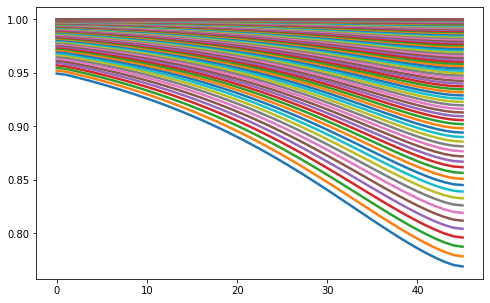

In [57]:
plt.plot(post_jump["dK"][:, :, 20])
plt.show()

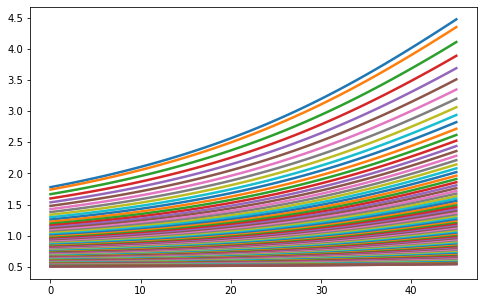

In [58]:
plt.plot(post_jump["dR"][:, :, 20])
plt.show()

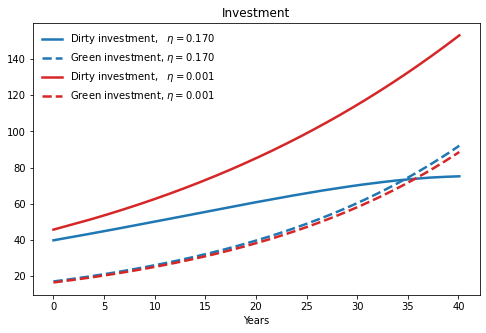

In [38]:
plt.plot(post_simul0["years"], post_simul0["I_d"], 
         label="Dirty investment,   $\eta = 0.170$", color="C0")
plt.plot(post_simul0["years"], post_simul0["I_g"], 
         label="Green investment, $\eta = 0.170$", color="C0", linestyle="dashed")

plt.plot(post_simul_test["years"], post_simul_test["I_d"], 
         label="Dirty investment,   $\eta = 0.001$", color="C3")
plt.plot(post_simul_test["years"], post_simul_test["I_g"], 
         label="Green investment, $\eta = 0.001$", color="C3", linestyle="dashed")

plt.xlabel("Years")
plt.title("Investment")
plt.legend()
# plt.savefig("Investment_compare.pdf")

In [39]:
post_jump["A_d"]

0.12

In [41]:
493 * 0.12 * 0.01

0.5916

In [42]:
post_simul_test["states"][:, 3] * 0.12 * 0.01

array([0.70956522, 0.71153367, 0.71350737, 0.71548633, 0.71747056,
       0.71946009, 0.72145491, 0.72345505, 0.72546053, 0.72747134,
       0.72948751, 0.73150905, 0.73353598, 0.7355683 , 0.73760603,
       0.73964919, 0.74169779, 0.74375184, 0.74581135, 0.74787635,
       0.74994684, 0.75202284, 0.75410436, 0.75619141, 0.75828402,
       0.76038219, 0.76248595, 0.76459529, 0.76671024, 0.76883081,
       0.77095702, 0.77308887, 0.77522639, 0.77736959, 0.77951848,
       0.78167306, 0.78383336, 0.78599937, 0.78817113, 0.79034864,
       0.79253192, 0.79472098, 0.79691584, 0.79911652, 0.80132302,
       0.80353536, 0.80575355, 0.80797762, 0.81020757, 0.81244343,
       0.8146852 , 0.8169329 , 0.81918654, 0.82144615, 0.82371173,
       0.8259833 , 0.82826088, 0.83054448, 0.83283411, 0.83512979,
       0.83743155, 0.83973938, 0.84205331, 0.84437335, 0.84669951,
       0.84903183, 0.85137029, 0.85371494, 0.85606577, 0.85842279,
       0.86078602, 0.86315547, 0.86553117, 0.86791311, 0.87030

Text(0.5, 1.0, 'Emission')

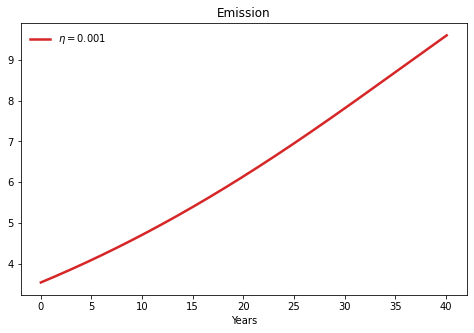

In [68]:
# plt.plot(post_simul0["years"], post_simul0["states"][:, 3] * 0.12 * 0.17, 
#          label="$\eta = 0.170$", color="C0")
plt.plot(post_simul_test["years"], post_simul_test["states"][:, 3] * post_jump["A_d"] * post_jump["eta"], 
         label="$\eta = 0.001$", color="C3")
plt.legend()
plt.xlabel("Years")
plt.title("Emission")

# plt.savefig("./Emission_compare.pdf")

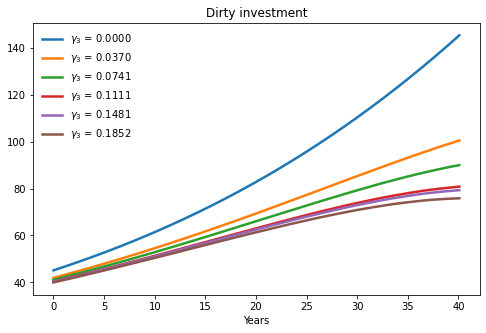

In [85]:
gamma_3_list = np.linspace(0., 1./3, 10)
for gamma3 in gamma_3_list[:6]:
    with open("./simul_post_{:.4f}_eta_{:.4f}".format(gamma3, post_jump["eta"]), "rb") as f:
        temp = pickle.load(f)
    plt.plot(temp["years"], temp["I_d"], label="$\\gamma_3$ = {:.4f}".format(gamma3))
    plt.xlabel("Years")
    plt.title("Dirty investment")

plt.legend()
# plt.savefig("Id_compare_{:.3f}.pdf".format(eta))

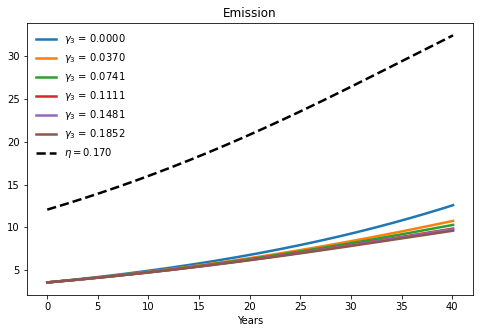

In [90]:
gamma_3_list = np.linspace(0., 1./3, 10)
for gamma3 in gamma_3_list[:6]:
    with open("./simul_post_{:.4f}_eta_{:.4f}".format(gamma3, post_jump["eta"]), "rb") as f:
        temp = pickle.load(f)
    plt.plot(temp["years"], temp["states"][:, 3] * post_jump["A_d"] * eta, label="$\\gamma_3$ = {:.4f}".format(gamma3))
    plt.xlabel("Years")
    plt.title("Emission")

plt.plot(post_simul0["years"], post_simul0["states"][:, 3] * 0.12 * 0.17, 
         label="$\eta = 0.170$", color="black", linestyle="dashed")
plt.legend()
# plt.savefig("Emission_compare_{:.3f}_include_0p17.pdf".format(eta))

In [82]:
0.05 * 0.12 * 85/ 0.115 * 0.8

3.547826086956522

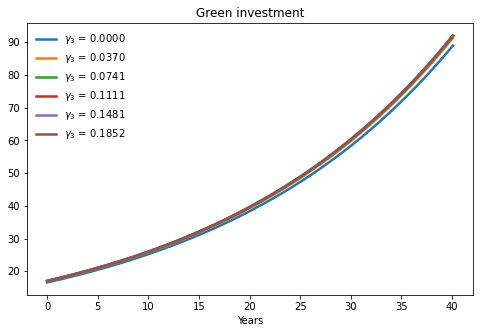

In [84]:
gamma_3_list = np.linspace(0., 1./3, 10)
for gamma3 in gamma_3_list[:6]:
    with open("./simul_post_{:.4f}_eta_{:.4f}".format(gamma3, post_jump["eta"]), "rb") as f:
        temp = pickle.load(f)
        
    plt.plot(temp["years"], temp["I_g"], label="$\\gamma_3$ = {:.4f}".format(gamma3))
    plt.xlabel("Years")
    plt.title("Green investment")

plt.legend()
# plt.savefig("Ig_compare_{:.3f}.pdf".format(eta))

In [9]:
pre_simul = simulate_pre(pre_jump)

NameError: name 'pre_jump' is not defined

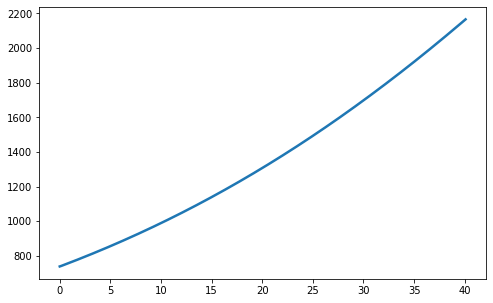

In [68]:
plt.plot(pre_simul["years"], np.exp(pre_simul["states"][:, 0]) )

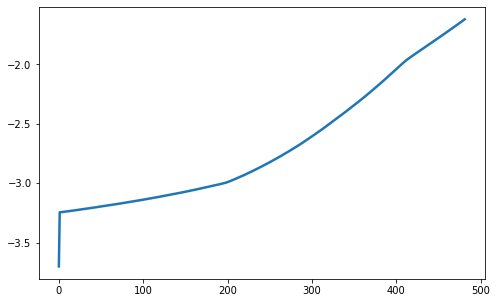

In [80]:
plt.plot(pre_simul["states"][:, 3])

In [85]:
pre_jump["alpha_l"], pre_simul["states"][:, 3]

(0.0,
 array([-3.7       , -3.2440132 , -3.2434841 , -3.24281123, -3.24204342,
        -3.2412126 , -3.24033957, -3.23943791, -3.23851645, -3.23758092,
        -3.23663504, -3.23568123, -3.23472105, -3.2337555 , -3.23278523,
        -3.23181065, -3.23083202, -3.22984951, -3.2288632 , -3.22787316,
        -3.22687941, -3.22588197, -3.22488084, -3.22387602, -3.22286748,
        -3.22185521, -3.22083921, -3.21981944, -3.21879589, -3.21776855,
        -3.21673739, -3.21570238, -3.21466352, -3.21362077, -3.21257412,
        -3.21152355, -3.21046902, -3.20941053, -3.20834805, -3.20728156,
        -3.20621826, -3.20516207, -3.20410897, -3.20305637, -3.20200261,
        -3.20094662, -3.19988772, -3.19882545, -3.19776101, -3.19670033,
        -3.19564055, -3.19457981, -3.19351694, -3.19245121, -3.19138211,
        -3.19030931, -3.1892326 , -3.18815182, -3.18706688, -3.1859777 ,
        -3.18488423, -3.18378642, -3.18268423, -3.18157763, -3.1804666 ,
        -3.17935109, -3.17823109, -3.17710657

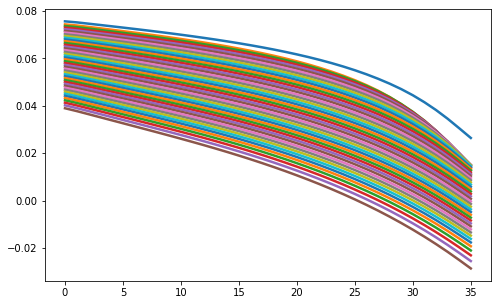

In [75]:
plt.plot(pre_jump["i_d"][:, :, 10, 1])
plt.show()

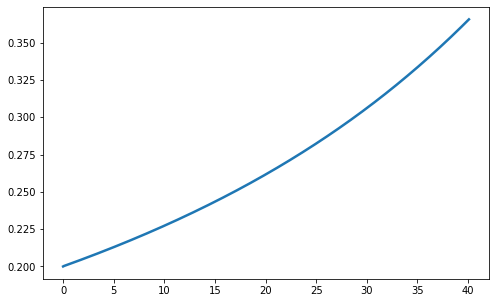

In [69]:
plt.plot(pre_simul["years"], pre_simul["states"][:, 1])

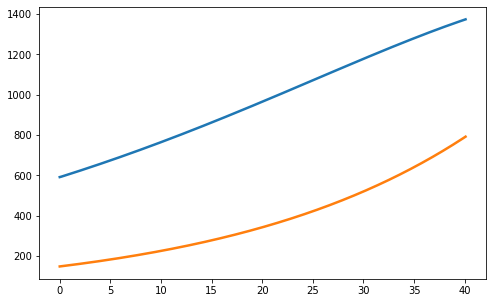

In [70]:
plt.plot(pre_simul["years"], pre_simul["states"][:, 4])
plt.plot(pre_simul["years"], pre_simul["states"][:, 5])

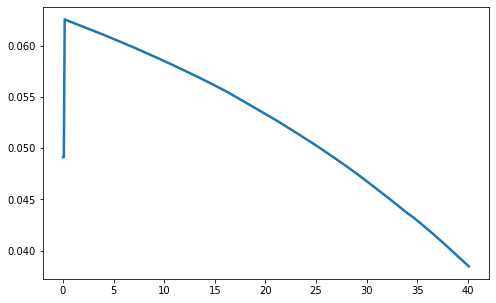

In [71]:
plt.plot(pre_simul["years"], pre_simul["I_d"] )

In [72]:
pre_simul["I_d"]

array([0.04913421, 0.04913421, 0.06260201, 0.0625642 , 0.0625284 ,
       0.06249392, 0.06246029, 0.06242721, 0.06239449, 0.06236201,
       0.06232967, 0.06229743, 0.06226525, 0.06223311, 0.062201  ,
       0.0621689 , 0.06213681, 0.06210472, 0.06207264, 0.06204055,
       0.06200847, 0.06197638, 0.0619443 , 0.06191221, 0.06188012,
       0.06184803, 0.06181593, 0.06178384, 0.06175174, 0.06171964,
       0.06168754, 0.06165543, 0.06162333, 0.06159122, 0.06155911,
       0.061527  , 0.06149489, 0.06146278, 0.06143067, 0.06139855,
       0.06136586, 0.06133253, 0.06129905, 0.06126546, 0.06123181,
       0.06119811, 0.06116439, 0.06113066, 0.06109686, 0.0610628 ,
       0.06102862, 0.06099438, 0.06096007, 0.06092574, 0.06089138,
       0.060857  , 0.06082262, 0.06078823, 0.06075383, 0.06071943,
       0.06068503, 0.06065062, 0.06061621, 0.0605818 , 0.06054738,
       0.06051297, 0.06047855, 0.06044413, 0.06040971, 0.06037529,
       0.06034086, 0.06030644, 0.06027201, 0.06023759, 0.06020